In [26]:
# Imports
from utils import read_json_file
from dotenv import load_dotenv
from typing import  List, Dict
from utils import print_progress
import os

load_dotenv()

True

In [27]:
# Load coins and markets

coins: List[Dict[str, any]] = read_json_file("data/coins.json")
markets: List[Dict[str, any]] = read_json_file("data/markets.json")

print("Coins: {}, Markets: {}".format(len(coins), len(markets)))

Coins: 10391, Markets: 10391


In [28]:
# Load charts

files = os.listdir("data/chart")
charts: Dict[str, any] = dict()

for idx, file in enumerate(files):
    coingecko_id = file.replace("_usd_chart_data.json", "") 
    chart = read_json_file("data/chart/" + file)
    if len(chart['prices']) > 0:
        charts[coingecko_id] = chart
    print_progress("Loading charts", idx, len(files), True)

print("\nCharts with price data count", len(charts))

 Loading charts idx: 7982 / 7983, 100.0%       
Charts with price data count 6722


In [57]:
# Find pump from charts
from download_chart_data import chart_data_to_df
from utils import print_progress, year_month_str
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  math


def is_pump(
    price: float, 
    prev_price: float, 
    pump_ratio: float,
    volume: float,
    min_volume: float
) -> bool:
    if math.isnan(prev_price) or math.isnan(price):
        return False
    return price >= prev_price * pump_ratio and volume > min_volume

def pumps_info(
    chart_data: List[Dict[str, any]], 
    pump_ratio: float,
    min_volume: float
) -> pd.DataFrame:
    # add create df timestamp, price, volume, marketcap
    df = chart_data_to_df(chart_data)

    # add month/year column
    tss = list(map(lambda  x: int(x[0] / 1000), chart_data["prices"]))
    df['Ym'] = list(map(lambda x: year_month_str(x), tss))

    # shift price and add pump bool
    df.insert(1, 'prev_price', df['price'].shift(1))
    df['pump'] = df.apply(
        lambda x: is_pump(x['price'], x['prev_price'], pump_ratio, x['total_volume'], min_volume),
        axis=1
    )

    # select pump rows
    return df.loc[df['pump'] == True]


pump_ratio = 1.5
min_volume = 500000
pump_dfs: Dict[str, pd.DataFrame] = dict()

# for each chart
for idx, key in enumerate(charts):
    chart = charts[key]
    print_progress("Searching for pumps", idx, len(charts), True)
    pump_dfs[key] = pumps_info(chart, pump_ratio, min_volume)

 Searching for pumps idx: 6721 / 6722, 100.0%       

In [58]:
# Counting pumps per month
from utils import year_month_keys

keys = year_month_keys(list(range(2017, 2024)), list(range(1, 13)))
zeros = np.zeros(len(keys))
empty_strs = map(lambda x: "", zeros)
result_df = pd.DataFrame(
    data={'year/month': keys, "pumps": zeros, "markets": empty_strs}
)

for idx, key in enumerate(keys):
    for df_key in pump_dfs:
        df = pump_dfs[df_key]
        pump_cnt = df.loc[df['Ym'] == key].shape[0]
        if pump_cnt > 0:
            result_df.loc[result_df['year/month'] == key, 'pumps'] += pump_cnt
            result_df.loc[result_df['year/month'] == key, 'markets'] += "{}, ".format(df_key)

    print_progress("Counting for pumps", idx, len(keys), True)

print("")
pd.set_option('display.max_colwidth', 24)
print(result_df.tail())

 Counting for pumps idx: 83 / 84, 98.8%       
   year/month  pumps markets
79    2023-08    0.0        
80    2023-09    0.0        
81    2023-10    0.0        
82    2023-11    0.0        
83    2023-12    0.0        


   year/month  pumps                  markets legend
67    2022-08  140.0  enq-enecuum, sperax,...  22-08
68    2022-09  122.0  enq-enecuum, fame-mm...  22-09
69    2022-10   98.0  enq-enecuum, fame-mm...  22-10
70    2022-11  126.0  nkn, kromatika, coco...  22-11
71    2022-12  105.0  higazers, sandwich-n...  22-12
72    2023-01  153.0  tortuga-staked-aptos...  23-01
73    2023-02  244.0  higazers, polydoge, ...  23-02
74    2023-03  116.0  fanc, hiens4, tortug...  23-03
75    2023-04  128.0  project-xeno, epillo...  23-04
76    2023-05  222.0  dinger-token, fanc, ...  23-05
77    2023-06   97.0  ribbit-meme, cocos-b...  23-06
78    2023-07   39.0  inedible-coin, borin...  23-07


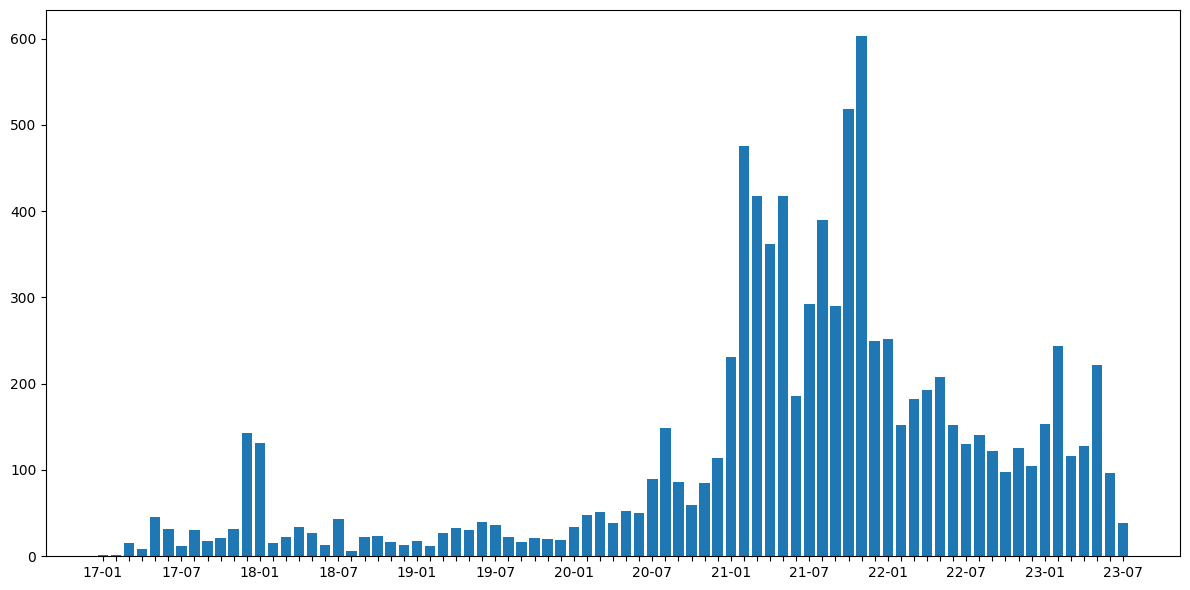

In [59]:
df = result_df
df = df.head(df.shape[1] - 8)
df = df.tail(100)
df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
print(df.tail(12))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df['legend'], df['pumps'])

for i, t in enumerate(ax.get_xticklabels()):
    if (i % 6) != 0:
        t.set_visible(False)

plt.tight_layout() 
plt.show()

In [53]:
key = '2023-06'
pd.set_option('display.max_colwidth', None)
row = result_df.loc[result_df['year/month'] == key]

markets = row['markets'].values[0].split(', ')[:-1]
for market in markets:
    print(market)
    
# uniswap cnt 8
# non uniswap cnt 8

osl-ai
furucombo
hiseals
dream-machine-token
marinade
sakura
pastel
adreward
iguverse-igu
lumerin
bedlingtonterriertoken
neon-coin
diamond-launch
harrypotterobamasonic10in
hifriends
wassie


In [32]:
# 
# download the candles (close vs high)
# more sanity checking on pumps. Inspect random 20 pumps
# where are the pumps happening. (Pumps by chain)

# 